# Analyze Correlation of Parties Behaviour

Birk & Steiglechner, 07.02.2022

In [1]:
import os
import re

import numpy as np
import pandas as pd

os.chdir('..')

from src.read_data_and_output import load_json
from src.definitions import PARTIES, BEHAVIOUR_TYPES


In [2]:
preprocessed_protocols = load_json('pt_marked.json')

FileNotFoundError: [Errno 2] No such file or directory: './dat/pt_marked.json'

In [ ]:
def find_party_person(text: str, PARTIES: list) -> list:
    """Find behaviour of single person

    Args:
        text (str): behaviour string

    Returns:
        list: ['person','content']
    """
    person = []
    for party in PARTIES:
        # Find all single persons (can have: Abg. / Dr. / or city + Name & Party)
        party_search_abg_dr_name_city_party = re.search(rf'(Abg\S*|) *(Dr\S*|) *(\w*|^\w*) *\w* \w* (\[\w*\]|) *\[{party}\].*$',text)
        if party_search_abg_dr_name_city_party:
            string = party_search_abg_dr_name_city_party.group(0)
            if (":" in string): # if there is additional content, append it
                split = re.split(r': *',string)
                person.append(party)
                person.append(split[0])
                person.append(split[1])
            else:
                person.append(party)
                person.append(string)
                person.append("None")
    return person

def find_party_abgeordneten(text: str, PARTIES: list) -> list:
    """Find all parties with abgeordneten Beteiligung

    Args:
        text (str): behaviour string
        PARTIES (list): PARTIES

    Returns:
        list: return all parties with Abgeordneten Beteiligung
    """
    parties = []
    for party in PARTIES:
        party_search = re.search(rf'Abg\S* \w* *({party})',text)
        if party_search:
            parties.append(party)
    return parties

def find_party_all(text: str, PARTIES: list) -> list:
    """Find party behaviour where all participated

    Args:
        text (str): preprocessed protocol-text
        PARTIES (list): Parties

    Returns:
        list: parties assigned to each behaviour
    """
    parties = []
    for party in PARTIES:
        party_search = re.search(rf'[^\[]{party}([^\]]|$)',text)
        if party_search:
            parties.append(party)
    return parties

In [ ]:
def find_last_speaker(protocol_text):
    start_index = protocol_text.rfind(r'\speaker')

    if start_index == -1:
        return 'CHAIR'
    else:
        return protocol_text[start_index:].split(r'}')[0].split(r'{')[1]


def split_behaviour(text: str) -> list:
    """split behaviour string if "-" is present

    Args:
        text (str): entire behaviour string

    Returns:
        list: split string if multiple behaviours
    """
    split = re.split(r'(–)',text)
    if len(split) > 1:
        split.remove('–')
    return split


def find_behaviour(text: str, behaviours: list) -> list:
    """find given behaviours in behaviour string

    Args:
        text (str): behaviour string
        behaviours (list): behaviours

    Returns:
        list: behaviour
    """
    list_behaviours = []
    for behaviour in behaviours:
        behaviour_search = re.search(rf'{behaviour}\S*',text)
        if behaviour_search:
            list_behaviours.append(behaviour_search.group(0))
    if len(list_behaviours) > 1:
        behaviour_string = ' & '.join(list_behaviours)
    elif len(list_behaviours) == 1:
        behaviour_string = list_behaviours[0]
    else: 
        behaviour_string = "None"
    return behaviour_string

In [ ]:
columns=['Party', 'Actor', 'Behaviour', 'ReferenceParty']

list_actor = []
list_parts = []
list_behaviours = []
list_reference = []

for i, protocol_text in preprocessed_protocols.items():
    print('\r', i, end='')
    behaviours = re.finditer(r'behaviour{(.*?)}', protocol_text)

    for b in behaviours:
        if not np.any([one_party in b.group(1) for one_party in PARTIES]):
            continue

        speaker = find_last_speaker(protocol_text[: b.start()]).split(':')[0]

        split = split_behaviour(b.group(1))

        for subsplit in split:
            parties_all = find_party_all(subsplit,PARTIES)
            parties_abgeordneten = find_party_abgeordneten(subsplit,PARTIES)
            parties_all_only = list(set(parties_all) - set(parties_abgeordneten))
            parties_person = find_party_person(subsplit,PARTIES)
            sub_behaviour = find_behaviour(subsplit,BEHAVIOUR_TYPES)

            if parties_all_only:
                for party in parties_all_only:
                    list_actor += [party]
                    list_parts += ['all']
                    list_reference += [speaker]
                    list_behaviours += [sub_behaviour]

            if parties_abgeordneten:
                for party in parties_abgeordneten:
                    list_actor += [party]
                    list_parts += ['abgeordnete']
                    list_reference += [speaker]
                    list_behaviours += [sub_behaviour]
            
            if parties_person:
                list_actor += [parties_person[0]]
                list_parts += [parties_person[1]]
                list_reference += [speaker]
                list_behaviours += [sub_behaviour]

#np.unique([a for a in re.findall('behaviour{(.*?)}', p) for p in preprocessed_protocols.values() if not np.any(
#    [(b in a) or ('[' in a) for b in BEHAVIOUR_TYPES])])

 9082

In [ ]:
df_behaviour = pd.DataFrame(data={
    'Party': list_actor, 'Actor': list_parts, 'Behaviour': list_behaviours, 'ReferenceParty': list_reference})

In [ ]:
behaviour_category = {
    'Beifall': 'sympathy',
    'Beifall & Heiterkeit': 'sympathy',
    'Beifall & Lachen': 'sympathy',
    'Beifall & Zuruf': 'sympathy',
    'Beifall & Zurufe': 'sympathy',
    'Beifall!': 'sympathy',
    'Beifall! & Zuruf': 'sympathy',
    'Beifall,': 'sympathy',
    'Heiterkeit': 'sympathy',
    'Heiterkeit & Zustimmung': 'sympathy',
    'Heiterkeit“!': 'sympathy',
    'Lachen': 'sympathy',
    'Lachen & Widerspruch': 'sympathy',
    'Lachen & Zurufe': 'sympathy',
    'Lachen!': 'sympathy',
    'Lachen,': 'sympathy',
    'None': 'sympathy',
    'Widerspruch': 'antipathy',
    'Widerspruch!': 'antipathy',
    'Widerspruch!]': 'antipathy',
    'Widerspruch,': 'antipathy',
    'Widerspruch?': 'antipathy',
    'Zuruf': 'antipathy',
    'Zuruf & Widerspruch': 'antipathy',
    'Zuruf & Widerspruch?': 'antipathy',
    'Zuruf & Zustimmung?': 'sympathy',
    'Zuruf,': 'antipathy',
    'Zuruf:': 'antipathy',
    'Zurufe': 'antipathy',
    'Zurufe & Widerspruch': 'antipathy',
    'Zurufe,': 'antipathy',
    'Zustimmung': 'sympathy',
    'Zustimmung!': 'sympathy',
    'Zustimmung?': 'sympathy',
}

In [ ]:
df_behaviour["category"] = [behaviour_category[behave] for behave in df_behaviour['Behaviour']]

In [ ]:
df_behaviour_all = df_behaviour[df_behaviour['Actor'].isin(['all', 'abgeordnete'])]

In [ ]:
behaviours_per_party = {}
PARTY_DICT = {}
i=0
for party in PARTIES:
    behaviours_per_party[party] = (df_behaviour_all['Party'].str.contains(party) & df_behaviour_all['ReferenceParty'].str.contains(party)).sum()
    PARTY_DICT[party] = i
    i+=1

In [ ]:
arr = np.empty((8, 8))

for p1 in PARTIES:
    for p2 in PARTIES:
        p1p2 = df_behaviour_all[df_behaviour_all['Party'].str.contains(p1) & df_behaviour_all['ReferenceParty'].str.contains(p2)]
        arr[PARTY_DICT[p1], PARTY_DICT[p2]] = (p1p2["category"] == 'sympathy').sum() / behaviours_per_party[p1].sum() - (p1p2["category"] == 'antipathy').sum() / behaviours_per_party[p1].sum()
        print('From', p1, 'to', p2, ':', 
            (p1p2["category"] == 'sympathy').sum() / behaviours_per_party[p1].sum() - (p1p2["category"] == 'antipathy').sum() / behaviours_per_party[p1].sum())

From CDU/CSU to CDU/CSU : 0.9910131058872478
From CDU/CSU to SPD : 0.3327231121281464
From CDU/CSU to LINKE : 0.010692739754524653
From CDU/CSU to BÜNDNIS 90/DIE GRÜNEN : 0.06378198460578323
From CDU/CSU to AfD : 0.0004576659038901601
From CDU/CSU to FDP : 0.1042230081131683
From CDU/CSU to fraktionslos : 0.0005824838776783857
From CDU/CSU to CHAIR : 0.36559184522571253
From SPD to CDU/CSU : 0.42195371872598414
From SPD to SPD : 0.9902655622918624
From SPD to LINKE : 0.06814106395696354
From SPD to BÜNDNIS 90/DIE GRÜNEN : 0.12462641960549908
From SPD to AfD : -0.010246776534881735
From SPD to FDP : 0.06724447101016139
From SPD to fraktionslos : 0.00025616941337204335
From SPD to CHAIR : 0.283451455896166
From LINKE to CDU/CSU : 0.07538871337421793
From LINKE to SPD : 0.22610419376819674
From LINKE to LINKE : 0.9846373040946541
From LINKE to BÜNDNIS 90/DIE GRÜNEN : 0.28055503933593506
From LINKE to AfD : -0.014061822461748127
From LINKE to FDP : 0.07699931859010097
From LINKE to fraktio

/tmp/ipykernel_28415/1699848201.py:6: RuntimeWarning: invalid value encountered in long_scalars
  arr[PARTY_DICT[p1], PARTY_DICT[p2]] = (p1p2["category"] == 'sympathy').sum() / behaviours_per_party[p1].sum() - (p1p2["category"] == 'antipathy').sum() / behaviours_per_party[p1].sum()
/tmp/ipykernel_28415/1699848201.py:8: RuntimeWarning: invalid value encountered in long_scalars
  (p1p2["category"] == 'sympathy').sum() / behaviours_per_party[p1].sum() - (p1p2["category"] == 'antipathy').sum() / behaviours_per_party[p1].sum())


From fraktionslos to CDU/CSU : nan
From fraktionslos to SPD : nan
From fraktionslos to LINKE : nan
From fraktionslos to BÜNDNIS 90/DIE GRÜNEN : nan
From fraktionslos to AfD : nan
From fraktionslos to FDP : nan
From fraktionslos to fraktionslos : nan
From fraktionslos to CHAIR : nan
From CHAIR to CDU/CSU : nan
From CHAIR to SPD : nan
From CHAIR to LINKE : nan
From CHAIR to BÜNDNIS 90/DIE GRÜNEN : nan
From CHAIR to AfD : nan
From CHAIR to FDP : nan
From CHAIR to fraktionslos : nan
From CHAIR to CHAIR : nan


In [ ]:
import matplotlib.pyplot as plt

<Figure size 1800x1200 with 0 Axes>

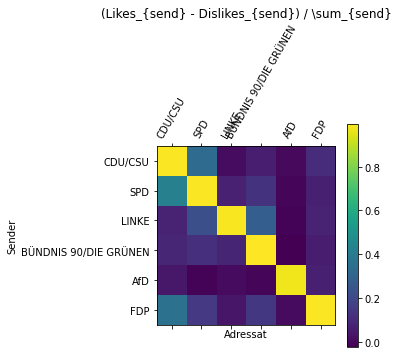

In [ ]:
plt.figure(dpi=300)
plt.matshow(arr[:6, :6])
plt.xticks(list(PARTY_DICT.values())[:6], list(PARTY_DICT.keys())[:6], rotation=60, rotation_mode='default', verticalalignment='bottom')
plt.yticks(list(PARTY_DICT.values())[:6], list(PARTY_DICT.keys())[:6])
plt.title(r'(Likes_{send} - Dislikes_{send}) / \sum_{send}')
plt.xlabel('Adressat')
plt.ylabel('Sender')
plt.colorbar(location='right', )
plt.show()